#   **1. Prepare: import libraries**

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,cross_val_score, train_test_split

!pip install pandas_profiling
from pandas_profiling import ProfileReport

## 1.1 Load dataset and checking info

In [ ]:
# Import file
from google.colab import files
uploaded = files.upload()

Saving fraudTest.csv to fraudTest.csv
Saving fraudTrain.csv to fraudTrain.csv


In [ ]:
fraud_train=pd.read_csv('fraudTrain.csv')
fraud_test=pd.read_csv('fraudTest.csv')

In [ ]:
# review DF
fraud_train.head()

In [ ]:
fraud_test.head()

In [ ]:
#Checking shape of df fraud_train
np.shape(fraud_train)

In [ ]:
# Checking info of fraud_train df
fraud_train.info()

In [ ]:
# Checking distribution of numerical values in fraud_train  df
fraud_train.describe()

In [ ]:
# Checking shape of df fraud_test
np.shape(fraud_test)

In [ ]:
# Checking info of df
fraud_test.info()

In [ ]:
# Checking distribution of numerical values in fraud_test  df
fraud_test.describe()

----> There is no null values in fraud_train and fraud_test dataframe

# **2.EDA**

## 2.1 Data cleaning

In [ ]:
fraud_train.duplicated().any()

In [ ]:
fraud_test.duplicated().any()

In [ ]:
# Remmove duplicates
fraud_train=fraud_train.drop_duplicates()
fraud_test=fraud_test.drop_duplicates()

## 2.2 Checking missing value

In [ ]:
fraud_train.isna().any()

In [ ]:
fraud_test.isna().any()

## 2.3 Checking corrlation

In [ ]:
train_corr = fraud_train.corr()
train_corr

In [ ]:
#Checking correlation in heatmap
plt.figure(figsize=(2,3))

sns.heatmap(train_corr, cmap="coolwarm", annot=True)
plt.show()

In [ ]:
prof = ProfileReport(fraud_train)
prof

There is no high corr between variables

## 2.4 Check number/percent of fraud

In [ ]:
# Check numnber of transaction each category
sns.countplot(data=fraud_train, y='category')
plt.show()

- grocery_pos, gas_transport, shopping_pos, home, kit_pets had the highest number of transations

In [ ]:
# Check number of gender in total transaction
sns.countplot(data=fraud_train, y='gender')
plt.show()

In [ ]:
# Top 20 city in which has the most transaction
sns.countplot(y="state", data=fraud_train,
              order=fraud_train.state.value_counts().iloc[:20].index)

In [ ]:
# Checking % of fraud in train set
fraud = fraud_train['is_fraud'].value_counts()
idx = fraud.index
val = fraud.values

plt.pie(val,
        labels = idx,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Fraud and non-fraud transaction')
plt.show()

In [ ]:
# Check which category has the most fraud transactions

# Separate the data by 'is_fraud' conditions
fraud_0 = fraud_train[fraud_train['is_fraud'] == 0]
fraud_1 = fraud_train[fraud_train['is_fraud'] == 1]

# Get the count of occurrences for each unique value in the 'category' column
counts_0 = fraud_0['category'].value_counts()
counts_1 = fraud_1['category'].value_counts()

# Calculate the percentage of occurrences for each category in both conditions
percent_0 = counts_0 / len(fraud_0) * 100
percent_1 = counts_1 / len(fraud_1) * 100

# Create a bar chart with the percentage for each category name in both conditions
plt.bar(percent_0.index, percent_0.values, label='is_fraud = 0')
plt.bar(percent_1.index, percent_1.values, label='is_fraud = 1')
plt.xlabel('category')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.legend()
plt.show()

- grocery_pos and shopping_net had no fraud transaction
- home_category, kid_pets, food_dimming, health_fifness had high percentage of fraud transaction

# **3.Feature Engineering**

Create funtion onehot_encoded to turn category values into binary values

In [ ]:
# def onehot_encoded(data, list_columns):

#     from sklearn.preprocessing import OneHotEncoder
#     import time
#     '''Input is a list of category columns that will be encoded
#     Output is a dataframe that have columns encoded and remove the old columns'''

#     print('Start onehot process')
#     st= time.time()
#     one_hot_data = pd.get_dummies(fraud_train, columns = list_columns)
#     return one_hot_data
#     et = time.time()
#     elaspe = (et-st)
#     print('=> The process done in', elaspe,'s')

## 3.1 Turn 'category' feature to binary values for fraud_train DF

In [ ]:
category_train_dum=pd.get_dummies(fraud_train['category'],drop_first=True)
gender_train_dum=pd.get_dummies(fraud_train['gender'],drop_first=True)

In [ ]:
# Drop the original 'category' ,'gender' , 'merchant' columns
fraud_train.drop('category', axis=1, inplace=True)
fraud_train.drop('gender', axis=1, inplace=True)
fraud_train.drop('merchant', axis=1, inplace=True)

# Note: Em drop cột merchant vì nếu encode ra, sau máy không đủ dung lượng để chạy

In [ ]:
fraud_train_dum=pd.concat([fraud_train, category_train_dum, gender_train_dum], axis=1)

In [ ]:
# onehot_encoded_data_train= onehot_encoded(fraud_train,list_columns = ['category', 'gender'])
# print(onehot_encoded_data_train)

In [ ]:
# # Add the one-hot encoded columns to the original DataFrame
# fraud_train = pd.concat([fraud_train, onehot_encoded_data_train], axis=1)

# # Drop the original 'category' column
# fraud_train.drop('category', axis=1, inplace=True)
# fraud_train.drop('gender', axis=1, inplace=True)
# fraud_train.drop('merchant', axis=1, inplace=True)

# # Check that 'category', 'gender', 'merchant' are one-hot encoded
# print(fraud_train.columns)

Đoạn này không biết sao khi em dùng hàm encode theo example code chị đưa thì các cột numerical values đều bị nhân đôi lên, dẫn đến đoạn sau bị lỗi, nên em sử dụng get_dummies thôi. Mong chị giải đáp phần này ạ

## 3.2 Turn 'category' feature to binary values for fraud_test DF

In [ ]:
category_test_dum=pd.get_dummies(fraud_test['category'],drop_first=True)
gender_test_dum=pd.get_dummies(fraud_test['gender'],drop_first=True)

In [ ]:
# Drop the original 'category' ,'gender' , 'merchant' columns
fraud_test.drop('category', axis=1, inplace=True)
fraud_test.drop('gender', axis=1, inplace=True)
fraud_test.drop('merchant', axis=1, inplace=True)

In [ ]:
fraud_test_dum=pd.concat([fraud_test, category_test_dum, gender_test_dum], axis=1)

In [ ]:
# onehot_encoded_data_test= onehot_encoded(fraud_test,list_columns = ['category', 'gender'])
# print(onehot_encoded_data_train)
# # Đoạn này k hiểu sao khi chạy lần lượt em bị lỗi là k có cột 'category' và 'gender' trong DF
# # nhưng khi em cho chạy lại đoạn read_csv file ở trên và chạy lại lệnh này thì lại được (em thử mấy lần đều vậy)

In [ ]:
# # Add the one-hot encoded columns to the original DataFrame
# fraud_test = pd.concat([fraud_test, onehot_encoded_data_test], axis=1)

# # Drop the original 'category' column
# fraud_test.drop('category', axis=1, inplace=True)
# fraud_test.drop('gender', axis=1, inplace=True)
# fraud_test.drop('merchant', axis=1, inplace=True)
# # Check that 'category', 'gender', 'merchant' are one-hot encoded
# print(fraud_test.columns)

In [ ]:
fraud_train_dum.head()

,amt,city_pop,is_fraud,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel,M
0,4.97,3495,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,107.23,149,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,220.11,4154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,45.00,1939,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,41.96,99,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


## 3.3 Split dataset to dependent and indepentden df

In [ ]:
# split train dataset
y_train= fraud_train_dum['is_fraud']
x_train= fraud_train_dum.drop(['is_fraud'], axis=1)
# Split test dataset
y_test= fraud_test_dum['is_fraud']
x_test= fraud_test_dum.drop(['is_fraud'], axis=1)

In [ ]:
# Check x_test DF
x_test.head()

,amt,city_pop,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel,M
0,2.86,333497,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,29.84,302,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,41.28,34496,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,60.05,54767,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,3.19,1126,0,0,0,0,0,0,0,0,0,0,0,0,1,1


##  3.4 Scaler data

In [ ]:
x_train_scaled=scaler.fit_transform(x_train)

In [ ]:
x_test_scaled=scaler.fit_transform(x_test)

In [ ]:
print(np.mean(x_train), np.std(x_train))
print(np.mean(x_train_scaled), np.std(x_train_scaled))

amt                  70.279095
city_pop          89057.759063
food_dining           0.070611
gas_transport         0.101500
grocery_net           0.035018
grocery_pos           0.095278
health_fitness        0.066149
home                  0.094965
kids_pets             0.087170
misc_net              0.048716
misc_pos              0.061504
personal_care         0.070093
shopping_net          0.075244
shopping_pos          0.089982
travel                0.031309
M                     0.452621
dtype: float64 amt                  159.951765
city_pop          302434.913407
food_dining            0.256174
gas_transport          0.301989
grocery_net            0.183825
grocery_pos            0.293598
health_fitness         0.248542
home                   0.293167
kids_pets              0.282084
misc_net               0.215273
misc_pos               0.240253
personal_care          0.255304
shopping_net           0.263785
shopping_pos           0.286156
travel                 0.174152
M        

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
print(np.mean(x_test), np.std(x_test))
print(np.mean(x_test_scaled), np.std(x_test_scaled))

amt                  69.392810
city_pop          88221.887918
food_dining           0.070662
gas_transport         0.101436
grocery_net           0.034957
grocery_pos           0.094568
health_fitness        0.065994
home                  0.094193
kids_pets             0.087620
misc_net              0.049246
misc_pos              0.062215
personal_care         0.070768
shopping_net          0.075180
shopping_pos          0.089597
travel                0.031399
M                     0.451367
dtype: float64 amt                  156.745800
city_pop          300390.621789
food_dining            0.256259
gas_transport          0.301905
grocery_net            0.183670
grocery_pos            0.292617
health_fitness         0.248271
home                   0.292097
kids_pets              0.282741
misc_net               0.216381
misc_pos               0.241545
personal_care          0.256437
shopping_net           0.263682
shopping_pos           0.285604
travel                 0.174393
M        

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


#   **4.Model Selection**

In [ ]:
# Create list of models
models={'LogisticRegression': LogisticRegression(), 'KNN':KNeighborsClassifier(),
       'Desision Tree': DecisionTreeClassifier(), 'Random Forest':RandomForestClassifier() }

In [ ]:
# Create variable to store results
results=[]

In [ ]:
y_train=y_train.values

In [ ]:
# for model in models.values():
#   kf=KFold(n_splits=6, random_state=42, shuffle=True)
#   cv_results=cross_val_score(model, x_train_scaled, y_train, cv=kf)
#   results.append(cv_results)

# plt.boxplot(results, labels=models.keys())
# plt.show()

## 4.1 LogisticRegression

In [ ]:
log_reg = LogisticRegression()

In [ ]:
log_reg.fit(x_train_scaled, y_train)
y_logreg_pred= log_reg.predict(x_test_scaled)

In [ ]:
log_reg.score(x_test_scaled, y_test)

0.9955499092167085

In [ ]:
# Compute confusion_matix of LogisticRegession classification
print(confusion_matrix(y_test, y_logreg_pred))

[[553246    328]
 [  2145      0]]


In [ ]:
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_logreg_pred))

ACCURACY OF THE MODEL:  0.9955499092167085


In [ ]:
# Compute resulting metrix of LogisticRegession classification
print(classification_report(y_test, y_logreg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719



Nhận xét:
-
-
-
-
-
-


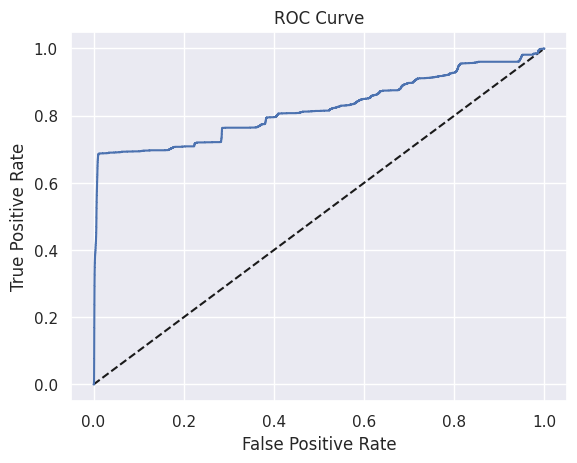

In [ ]:
# Plot ROC curve
y_logreg_pred_prob= log_reg.predict_proba(x_test_scaled)[:,1]
# Generate ROX curve values: fpr, tpr, thresholds
fpr, tpr, thresholds= roc_curve(y_test, y_logreg_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## 4.2 KNeighborsClassifier
 máy em k chạy được Knn, nặng quá nên em cứ để đây thôi ạ

In [ ]:
# # Initiate knn classifier
# knn=KNeighborsClassifier(n_neighbors=10)

Choose n_neighbors

In [ ]:
# # Setup arrays to store train and test accuracies
# neighbors = np.arange(1, 20)
# train_accuracy = np.empty(len(neighbors))
# test_accuracy = np.empty(len(neighbors))
# # Loop over different values of k
# for i, k in enumerate(neighbors):
#     # Setup a k-NN Classifier with k neighbors: knn
#     knn = KNeighborsClassifier(n_neighbors = k)
#     # Fit the classifier to the training data
#     knn.fit(x_train_scaled, y_train)
#     #Compute accuracy on the training set
#     train_accuracy[i] = knn.score(x_train_scaled, y_train)
#     #Compute accuracy on the testing set
#     test_accuracy[i] = knn.score(x_test_scaled, y_test)
# # Generate plot
# plt.title('k-NN: Varying Number of Neighbors')
# plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
# plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
# plt.legend()
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
# plt.show()


In [ ]:
# knn.fit(x_train_scaled, y_train)
# y_knn_pred= knn.predict(x_test_scaled)
# # Check accuracy
# knn.score(x_test_scaled, y_test)

0.9976804824020773

In [ ]:
# # Compute confusion_matix of KNeighbors classification
# print(confusion_matrix(y_test, y_knn_pred))

In [ ]:
# # Compute resulting metrix of KNeighbors classification
# print(classification_report(y_test, y_knn_pred))

## 4.3 RandomForest Classifier

In [ ]:
# creating a RF classifier
rf = RandomForestClassifier(n_estimators = 100)

In [ ]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rf.fit(x_train_scaled, y_train)
# performing predictions on the test dataset
y_rf_pred = rf.predict(x_test_scaled)

In [ ]:
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_rf_pred))

ACCURACY OF THE MODEL:  0.9974411528128425


In [ ]:
# Compute confusion_matix of KNeighbors classification
print(confusion_matrix(y_test, y_rf_pred))

[[553001    573]
 [   849   1296]]


In [ ]:
# Compute resulting metrix of KNeighbors classification
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.69      0.60      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.80      0.82    555719
weighted avg       1.00      1.00      1.00    555719



## 4.4 DecisionTree Classifier

In [ ]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtc.fit(x_train_scaled,y_train)

#Predict the response for test dataset
y_dct_pred = dtc.predict(x_test_scaled)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_dct_pred))

Accuracy: 0.9959367953947948


In the 3 models above, RandomForest has the highest accuracy of 0.9974---> choose RandomForest as the evaluation model.